In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Physics-Informed Neural Networks (PINNs) - Forward Problems

We are going to use the `equinox` library to solve forward problems using PINNs.

We will be using a simple multi-layer perceptron to represent the solution of a PDE. The architecture of the network is given by:

$$
f(x) = g^{(L)}(W^{(L)}g^{(L-1)}(W^{(L-1)}\ldots g^{(1)}(W^{(1)}x + b^{(1)}) + b^{(L-1)}) + b^{(L)})
$$

where $x$ is the input, $W^{(l)}$ and $b^{(l)}$ are the weights and biases of the $l$-th layer, and $g^{(l)}$ is the activation function of the $l$-th layer.

For PINNS applications, it is recommended that:
+ We use the tanh activation function all layers.
+ We use 128 to 512 neurons per layer.
+ We use 3 to 5 layers.
+ Use the Glorot initialization (this is the default in `equinox`).

In this simple problem, we will enforce the boundary conditions by hand.

You will notice that our first attempt will fail.
To make it work, we will have to *non-dimensionalize* the problem.

We are going to solve a Poisson's equation with a source term:

$$
\begin{aligned}
    -k\Delta u(x, y) &= f(x, y) \quad \text{in} \quad \Omega = [0, L_x]\times [0, L_y], \\
    u(x, y) &= 0 \quad \text{on} \quad \partial \Omega.
\end{aligned}
$$

We will use a common trick to construct an exact solution. We will use the following function:

$$
u(x, y) = u_0 \sin(\pi x/L_x) \sin(10\pi y/L_y).
$$

The boundary conditions are satisfied by construction. The source term is:

In [71]:
import sympy
xs, ys, ks, u0s, Lxs, Lys = sympy.symbols('x y k u_0 L_x L_y')

us = u0s * sympy.sin(sympy.pi * xs / Lxs) ** 2 * sympy.sin(10 * sympy.pi * ys / Lys) ** 2
fs = -ks * (sympy.diff(us, xs, 2) + sympy.diff(us, ys, 2))
sympy.simplify(fs)

2*pi**2*k*u_0*(100*L_x**2*(sin(10*pi*y/L_y)**2 - cos(10*pi*y/L_y)**2)*sin(pi*x/L_x)**2 - L_y**2*sin(10*pi*y/L_y)**2*cos(2*pi*x/L_x))/(L_x**2*L_y**2)

This is a common trick for constructing exact solutions. Remember it!

Let's use the following parameters:

In [55]:
u0 = 500 # degrees Kelvin
k = 1000.0 # thermal conductivity in W/mK
Lx = 0.1 # meters
Ly = 1 # meters

We are going to solve this boundary value problem using PINNS.
Our model will be:

$$
u(x,y) = x(1-x)y(1-y)\text{MLP}(x, y),
$$

where $\text{MLP}(x, y)$ is a multi-layer perceptron, and $x(1-x)y(1-y)$ is a polynomial that satisfies the boundary conditions.
This is also a common trick for enforcing boundary conditions in PINNS.

Let's make the model:

In [66]:
import equinox as eqx
import jax.numpy as jnp
import jax.random as jrandom

key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)
# MLP parameters
width_size = 128
depth = 4
mlp = eqx.nn.MLP(2, 1, width_size, depth, jnp.tanh, key=subkey)
u_hat = lambda x, y, mlp: x * (Lx - x) * y * (Ly - y) * mlp(jnp.array([x, y]))[0]

Let's see how it looks like before we train it:

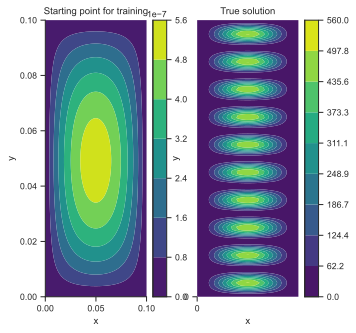

In [74]:
from jax import vmap

v_u_hat = eqx.filter_jit(vmap(u_hat, in_axes=(0, 0, None)))

x = jnp.linspace(0, Lx, 100)
y = jnp.linspace(0, Ly, 100)
X, Y = jnp.meshgrid(x, y)
u_pred = v_u_hat(X.flatten(), Y.flatten(), mlp).reshape(X.shape)

# the true solution for comparison
u_true = u0 * jnp.sin(jnp.pi * X / Lx) ** 2 * jnp.sin(10 * jnp.pi * Y / Ly) ** 2

fig, ax = plt.subplots(1,2, figsize=(50 * Lx, 50 * Ly))
c = ax[0].contourf(X, Y, u_pred, cmap='viridis')
fig.colorbar(c, ax=ax[0])
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Starting point for training')
sns.despine(trim=True);
c = ax[1].contourf(X, Y, u_true, cmap='viridis', levels=jnp.linspace(0, 560, 10))
fig.colorbar(c, ax=ax[1])
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('True solution')
sns.despine(trim=True);

We are going to train this by minimizing the following loss function:

$$
\mathcal{L}(\theta) = \int_{\Omega} \left[ \Delta u(x, y) + f(x, y) \right]^2 \, dx \, dy.
$$

The first step, is to turn the loss function into an expectation.
Construct the random variable $\mathbf{X} = (X,Y)$ uniformly distributed in $\Omega$.
Then, the loss function can be written as:

$$
\mathcal{L}(\theta) = |\Omega|\mathbb{E}\left[ \left[ \Delta u(\mathbf{X}) + f(\mathbf{X}) \right]^2 \right].
$$

Notice that the volume of $\Omega$, $\Omega|$, appears as a constant factor.
Where did it come from?
Recall the probability density function of $\mathbf{X}$ is:

$$
p(\mathbf{x}) = \frac{1}{|\Omega|} \quad \text{if} \quad \mathbf{x} \in \Omega, \quad \text{and} \quad 0 \quad \text{otherwise}.
$$

So:

$$
\int_{\Omega} \left[ \Delta u(\mathbf{x}) + f(\mathbf{x}) \right]^2 \, d\mathbf{x}
= \int_{\Omega} \left[ \Delta u(\mathbf{x}) + f(\mathbf{x}) \right]^2 |\Omega|p(\mathbf{x}) \, d\mathbf{x}
= |\Omega|\mathbb{E}\left[ \left[ \Delta u(\mathbf{X}) + f(\mathbf{X}) \right]^2 \right].
$$

We can approximate this expectation by sampling a finite number of points from $\Omega$ and averaging the loss function over these points.
This is what we will be doing in each iteration of the training process.

In [50]:
from jax import grad

# First order derivatives
u_x = grad(u_hat, argnums=0)
u_y = grad(u_hat, argnums=1)

# Second order deerivatives
u_xx = grad(u_x, argnums=0)
u_yy = grad(u_y, argnums=1)

# The Laplacian
D2_u = lambda x, y, mlp: u_xx(x, y, mlp) + u_yy(x, y, mlp)

# The source term
source_term = lambda x, y: 2 * jnp.pi ** 2 * k * u0 * jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y)

# The PDE residual (vectorize)
pde_residual = vmap(
    lambda x, y, mlp: D2_u(x, y, mlp) + source_term(x, y),
    in_axes=(0, 0, None))

# Finally the loss function:
loss = lambda mlp, x, y: jnp.mean(jnp.square(pde_residual(x, y, mlp)))

The training loop:

In [51]:
def train(
        mlp,
        key,
        optimizer,
        num_collocation_residual=512,
        num_iter=10_000,
        freq=1,
    ):

    @eqx.filter_jit
    def step(opt_state, mlp, xs, ys):
        value, grads = eqx.filter_value_and_grad(loss)(mlp, xs, ys)
        updates, opt_state = optimizer.update(grads, opt_state)
        mlp = eqx.apply_updates(mlp, updates)
        return mlp, opt_state, value
    
    opt_state = optimizer.init(eqx.filter(mlp, eqx.is_inexact_array))
    
    losses = []
    for i in range(num_iter):
        key, subkey = jrandom.split(key)
        xb = jrandom.uniform(subkey, (num_collocation_residual,))
        key, subkey = jrandom.split(key)
        yb = jrandom.uniform(subkey, (num_collocation_residual,))
        mlp, opt_state, value = step(opt_state, mlp, xb, yb)
        if i % freq == 0:
            losses.append(value)
            print(f"Step {i}, residual loss {value:.3e}")
    return mlp, losses

In [52]:
import optax

optimizer = optax.adam(1e-3)
trained_mlp, losses = train(mlp, key, optimizer, num_collocation_residual=256, num_iter=2_000, freq=100)

Step 0, residual loss 2.329e+13
Step 100, residual loss 2.582e+13
Step 200, residual loss 2.264e+13
Step 300, residual loss 2.721e+13
Step 400, residual loss 2.450e+13
Step 500, residual loss 2.335e+13
Step 600, residual loss 2.610e+13
Step 700, residual loss 2.483e+13
Step 800, residual loss 2.359e+13
Step 900, residual loss 2.308e+13
Step 1000, residual loss 2.529e+13
Step 1100, residual loss 2.404e+13
Step 1200, residual loss 2.603e+13
Step 1300, residual loss 2.459e+13
Step 1400, residual loss 2.343e+13
Step 1500, residual loss 2.293e+13
Step 1600, residual loss 2.326e+13
Step 1700, residual loss 2.600e+13
Step 1800, residual loss 2.402e+13
Step 1900, residual loss 2.454e+13


Let's visualize first the evolution of the loss function:

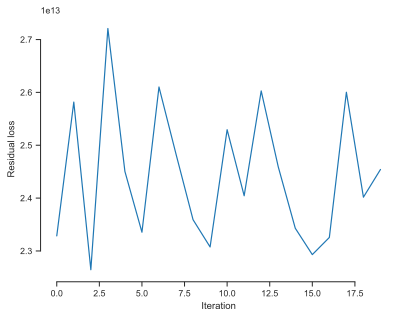

In [53]:
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_xlabel('Iteration')
ax.set_ylabel('Residual loss')
sns.despine(trim=True);

It's not working! The loss function is not decreasing.

## Non-dimensionalization of Partial Differential Equations

The problem is that the initialization of the network weights is completely off.
Glorot initialization is assuming that the input data and the output data are scaled to be around zero (scale of about 1).
To get our problem to that scale, we need to non-dimensionalize it.



Let's visualize the solution:

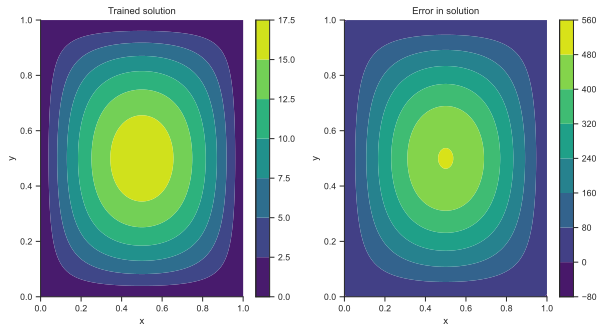

In [54]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
u_pred = v_u_hat(X.flatten(), Y.flatten(), trained_mlp).reshape(X.shape)
c = ax[0].contourf(X, Y, u_pred, cmap='viridis')
fig.colorbar(c, ax=ax[0])
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Trained solution')
sns.despine(trim=True);
c = ax[1].contourf(X, Y, u_true - u_pred, cmap='viridis')
fig.colorbar(c, ax=ax[1])
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('Error in solution')
sns.despine(trim=True);

Let's try to `jit` the entire training loop to see how much faster it runs.

In [110]:
from jax import lax

@eqx.filter_jit
def train_jit(
        mlp,
        key,
        optimizer,
        num_collocation_residual=512,
        num_iter=10_000,
    ):

    def step(opt_state, mlp, xs, ys):
        grads = eqx.filter_grad(loss)(mlp, xs, ys)
        updates, opt_state = optimizer.update(grads, opt_state)
        mlp = eqx.apply_updates(mlp, updates)
        return mlp, opt_state
    
    opt_state = optimizer.init(mlp)
    init_val = (key, mlp, opt_state)
    def body_fun(i, val):
        key, mlp, opt_state = val
        key, subkey = jrandom.split(key)
        xb = jrandom.uniform(subkey, (num_collocation_residual,))
        key, subkey = jrandom.split(key)
        yb = jrandom.uniform(subkey, (num_collocation_residual,))
        mlp, opt_state = step(opt_state, mlp, xb, yb)
        return (key, mlp, opt_state)
    
    final_val = lax.fori_loop(0, num_iter, body_fun, init_val)
    return final_val[1]

In [132]:
trained_mlp = train_jit(mlp, key, optimizer, num_collocation_residual=256, num_iter=10_000)

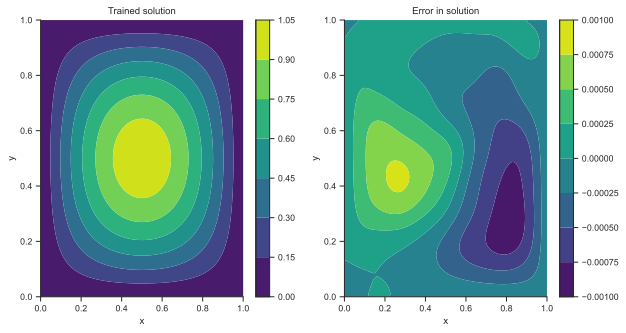

In [123]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
u_pred = v_u_hat(X.flatten(), Y.flatten(), trained_mlp).reshape(X.shape)
c = ax[0].contourf(X, Y, u_pred, cmap='viridis')
fig.colorbar(c, ax=ax[0])
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Trained solution')
sns.despine(trim=True);
c = ax[1].contourf(X, Y, u_true - u_pred, cmap='viridis')
fig.colorbar(c, ax=ax[1])
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('Error in solution')
sns.despine(trim=True);

Let's investigate another way to do it. We will generate the training data before training loop.

In [124]:
@eqx.filter_jit
def train_batch(
        mlp,
        key,
        optimizer,
        num_collocation_residual=512,
        num_iter=10_000,
    ):
    xs = jrandom.uniform(key, (num_iter, num_collocation_residual, 2))
    
    def step(opt_state, mlp, xb, yb):
        value, grads = eqx.filter_value_and_grad(loss)(mlp, xb, yb)
        updates, opt_state = optimizer.update(grads, opt_state)
        mlp = eqx.apply_updates(mlp, updates)
        return mlp, opt_state, value
    
    opt_state = optimizer.init(mlp)
    init = (opt_state, mlp)
    def f(carry, x):
        opt_state, mlp = carry
        xb, yb = x[:, 0], x[:, 1]
        mlp, opt_state, value = step(opt_state, mlp, xb, yb)
        return (opt_state, mlp), value
    
    (opt_state, mlp), losses = lax.scan(f, init, xs)
    return mlp, losses

In [130]:
trained_mlp, losses = train_batch(mlp, key, optimizer, num_collocation_residual=256, num_iter=10_000)

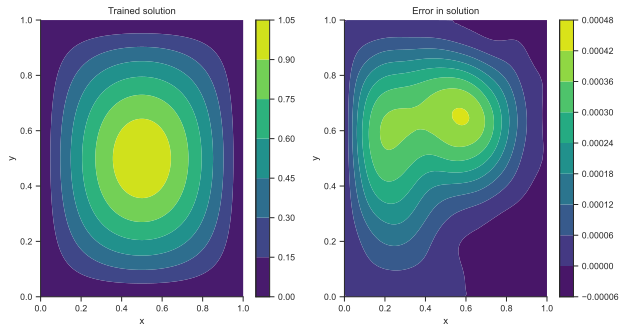

In [131]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
u_pred = v_u_hat(X.flatten(), Y.flatten(), trained_mlp).reshape(X.shape)
c = ax[0].contourf(X, Y, u_pred, cmap='viridis')
fig.colorbar(c, ax=ax[0])
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Trained solution')
sns.despine(trim=True);
c = ax[1].contourf(X, Y, u_true - u_pred, cmap='viridis')
fig.colorbar(c, ax=ax[1])
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('Error in solution')
sns.despine(trim=True);